# Cargar imagenes


In [ ]:
import os
import shutil
import cv2
import numpy as np
import matplotlib.pyplot as plt
import keras
from random import randint
from keras.layers import Dense
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Flatten,Dropout

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("tawsifurrahman/covid19-radiography-database")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/covid19-radiography-database


In [ ]:
direccion = path
for folder in os.listdir(direccion):
    subfolder_path = os.path.join(direccion, folder)
    if os.path.isdir(subfolder_path):
        for sub_folder in os.listdir(subfolder_path):
            sub_subfolder_path = os.path.join(subfolder_path, sub_folder)
            print(sub_subfolder_path)

/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Lung_Opacity.metadata.xlsx
/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal.metadata.xlsx
/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/README.md.txt
/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID.metadata.xlsx
/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal
/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Lung_Opacity
/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Viral Pneumonia.metadata.xlsx
/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Viral Pneumonia
/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID


In [ ]:
clases = ['Normal', 'COVID']
lista = []
lista_labels = []
for clase in clases:
  direccion_clase = os.path.join("/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset",clase,"images")
  for subdir in os.listdir(direccion_clase):
    subdir_direccion = os.path.join(direccion_clase,subdir)
    imagen_numpy = cv2.imread(subdir_direccion,cv2.IMREAD_GRAYSCALE)
    imagen_resize = cv2.resize(imagen_numpy,(200,200))
    lista_labels.append(1) if clase == "COVID" else lista_labels.append(0)
    lista.append(imagen_resize)


In [ ]:
x = np.array(lista)
y = np.array(lista_labels)

## 1. Análisis Exploratorio de Datos (20 %)


In [ ]:
unique_shapes = set(img.shape for img in x)
print("Dimensiones únicas de las imágenes:", unique_shapes) # se seteo las dimensiones de la imagen anteriormente en 200 aca solo verificamos que este bien

Dimensiones únicas de las imágenes: {(200, 200)}


In [ ]:
import numpy as np

# Buscar imágenes con valores anómalos (pixeles fuera del rango 0-255)
imagenes_corruptas = [i for i in range(len(x)) if x[i].min() < 0 or x[i].max() > 255]

# Ver si encontramos imágenes corruptas
if imagenes_corruptas:
    print(f"Se encontraron {len(imagenes_corruptas)} imágenes corruptas.")
else:
    print("No hay imágenes corruptas en el dataset.")

No hay imágenes corruptas en el dataset.


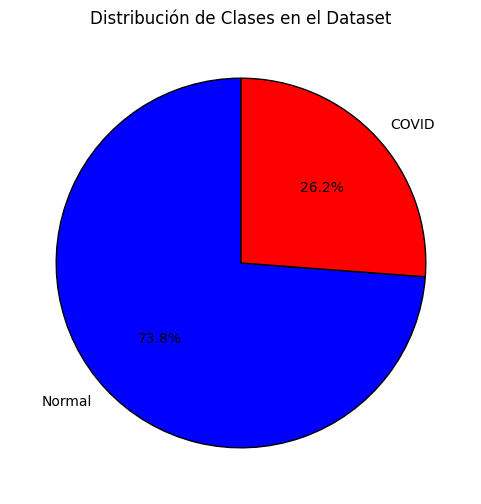

- Cantidad de imágenes - Normal: 10192, COVID: 3616
- Ratio de clases (Normal/COVID): 2.82
- El dataset está desbalanceado, considera aplicar técnicas de balanceo.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Contar la cantidad de imágenes por clase
num_normal = np.sum(y == 0)
num_covid = np.sum(y == 1)

# Crear el gráfico de pastel
plt.figure(figsize=(6, 6))
plt.pie([num_normal, num_covid], labels=["Normal", "COVID"], autopct='%1.1f%%', colors=['blue', 'red'], startangle=90, wedgeprops={'edgecolor': 'black'})

# Configuración del gráfico
plt.title("Distribución de Clases en el Dataset")
plt.show()

# Evaluar balanceo del dataset
ratio = num_normal / num_covid
print(f"- Cantidad de imágenes - Normal: {num_normal}, COVID: {num_covid}")
print(f"- Ratio de clases (Normal/COVID): {ratio:.2f}")

if ratio < 0.8 or ratio > 1.2:
    print("- El dataset está desbalanceado, considera aplicar técnicas de balanceo.")
else:
    print("- El dataset está relativamente balanceado.")


# 2.Preprocesamiento de imagenes

In [ ]:
indices_normal = np.where(y == 0)[0]  # Índices de imágenes "Normal"
indices_covid = np.where(y == 1)[0]   # Índices de imágenes "COVID"

# Seleccionar 6,000 imágenes aleatorias de la clase Normal
indices_normal_subsampled = np.random.choice(indices_normal, 6000, replace=False)

# Unir con todos los datos de COVID
indices_finales = np.concatenate([indices_normal_subsampled, indices_covid])

# Barajar
np.random.shuffle(indices_finales)

# Crear nuevo dataset balanceado parcialmente
x_balanced = x[indices_finales]
y_balanced = y[indices_finales]

print(f"Nuevo dataset tras submuestreo - Normal: {np.sum(y_balanced == 0)}, COVID: {np.sum(y_balanced == 1)}")

Nuevo dataset tras submuestreo - Normal: 6000, COVID: 3616


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Aplicar Data Augmentation solo a imágenes COVID
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.05,
    zoom_range=0.1,
    brightness_range=[0.8, 1.2]
)

# Extraer imágenes de COVID
covid_images = x_balanced[y_balanced == 1]
num_extra = 6000 - len(covid_images)  # Cuántas imágenes extra necesitamos

x_augmented = []
y_augmented = []

for i in range(num_extra):
    img = covid_images[i % len(covid_images)]  # Seleccionar imagen de COVID (repite si es necesario)
    img = img.reshape((1,) + img.shape + (1,))  # Agregar dimensión extra
    aug_iter = datagen.flow(img, batch_size=1)  # Aplicar Data Augmentation
    x_augmented.append(next(aug_iter).reshape(img.shape[1:3]))  # ✅ USAMOS next()
    y_augmented.append(1)  # Etiqueta COVID

# Convertir listas en arrays de NumPy
x_augmented = np.array(x_augmented)
y_augmented = np.array(y_augmented)

# Unir datos originales con los aumentados
x_balanced = np.concatenate([x_balanced, x_augmented], axis=0)
y_balanced = np.concatenate([y_balanced, y_augmented], axis=0)

# Mezclar nuevamente
indices = np.random.permutation(len(x_balanced))
x_balanced = x_balanced[indices]
y_balanced = y_balanced[indices]

print(f"Dataset final balanceado - Normal: {np.sum(y_balanced == 0)}, COVID: {np.sum(y_balanced == 1)}")

Dataset final balanceado - Normal: 6000, COVID: 6000


In [ ]:
#Necesitamos aleatorizar el orden del conjunto de datos para despues dividir en test y train
indices = np.random.permutation(len(x_balanced))

# Randomizamos el array
x_shuffled = x_balanced[indices]
y_shuffled = y_balanced[indices]

In [ ]:
x_shuffled.shape

(12000, 200, 200)

In [ ]:
y_shuffled.size

12000

In [ ]:
# División 80% - 20%
#Justificar en el informe porque se hizo esta division
split_idx = int(0.8 * len(x_shuffled))

#Entrenamiento
x_train, y_train = x_shuffled[:split_idx], y_shuffled[:split_idx]

#Prueba
x_test, y_test = x_shuffled[split_idx:], y_shuffled[split_idx:]

#Tamaños de los conjuntos
print("Tamaño de x_train:", x_train.shape)
print("Tamaño de y_train:", y_train.shape)
print("Tamaño de x_test:", x_test.shape)
print("Tamaño de y_test:", y_test.shape)

Tamaño de x_train: (9600, 200, 200)
Tamaño de y_train: (9600,)
Tamaño de x_test: (2400, 200, 200)
Tamaño de y_test: (2400,)


In [ ]:
x_test_copia = x_test.copy()

In [ ]:
num_classes = 2
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [ ]:
#normalizamos las imagenes del dataset
x_train = x_train / 255.0
x_test = x_test / 255.0

In [ ]:
x_train = x_train.reshape(-1, 200, 200, 1)
x_test = x_test.reshape(-1,200,200, 1)

Durante la carga de las imagenes dejamos las imagenes en escala de grises y definimos el tamaño de las imagenes.
Sin embargo, si es necesario para que el modelo aprenda bien podemos hacer data aumentacion de imagenes para que capte mejor los patrones

# Arquitectura red neuronal

In [ ]:
model = Sequential()
#Capa convolusional 1
model.add(Conv2D(filters = 8, kernel_size = (5,5), activation ='relu', input_shape = (200,200,1)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
# capa convolusional 2
model.add(Conv2D(filters = 16, kernel_size = (5,5), activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# capa convolusional
model.add(Conv2D(filters = 32, kernel_size = (5,5), activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))


# fully connected
model.add(Flatten())
model.add(Dense(200, activation = "relu"))
model.add(Dropout(0.4))
model.add(Dense(2, activation = "sigmoid"))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 196, 196, 8)    │           208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 98, 98, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 98, 98, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 94, 94, 16)     │         3,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 47, 47, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 47, 47, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 43, 43, 32)     │        12,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 21, 21, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 21, 21, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 14112)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 200)            │     2,822,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           402 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,839,258 (10.83 MB)

 Trainable params: 2,839,258 (10.83 MB)

 Non-trainable params: 0 (0.00 B)

# Entrenamiento

In [ ]:
optimizer = keras.optimizers.SGD(learning_rate=0.01)

In [ ]:
#model.compile(optimizer="sgd", loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
from tensorflow.keras import metrics

In [ ]:
model.compile(optimizer="sgd", loss='categorical_crossentropy', metrics=['accuracy',metrics.Precision(name='precision')])

In [ ]:
history = model.fit(x_train, y_train, batch_size=8, epochs=12, verbose=2, validation_split=0.1)

Epoch 1/12
1080/1080 - 15s - 14ms/step - accuracy: 0.6995 - loss: 0.5726 - precision: 0.6899 - val_accuracy: 0.7635 - val_loss: 0.5558 - val_precision: 0.7353
Epoch 2/12
1080/1080 - 14s - 13ms/step - accuracy: 0.7772 - loss: 0.4718 - precision: 0.7355 - val_accuracy: 0.7802 - val_loss: 0.4634 - val_precision: 0.7470
Epoch 3/12
1080/1080 - 7s - 6ms/step - accuracy: 0.8108 - loss: 0.4200 - precision: 0.7805 - val_accuracy: 0.7969 - val_loss: 0.4626 - val_precision: 0.7393
Epoch 4/12
1080/1080 - 7s - 6ms/step - accuracy: 0.8258 - loss: 0.3821 - precision: 0.8040 - val_accuracy: 0.8302 - val_loss: 0.3920 - val_precision: 0.7939
Epoch 5/12
1080/1080 - 11s - 10ms/step - accuracy: 0.8420 - loss: 0.3497 - precision: 0.8214 - val_accuracy: 0.8625 - val_loss: 0.3506 - val_precision: 0.8465
Epoch 6/12
1080/1080 - 10s - 9ms/step - accuracy: 0.8595 - loss: 0.3173 - precision: 0.8324 - val_accuracy: 0.8781 - val_loss: 0.3019 - val_precision: 0.8244
Epoch 7/12
1080/1080 - 6s - 6ms/step - accuracy: 0.

In [ ]:
loss, accuracy,precision  = model.evaluate(x_test, y_test, verbose=1)

75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9055 - loss: 0.2430 - precision: 0.8886


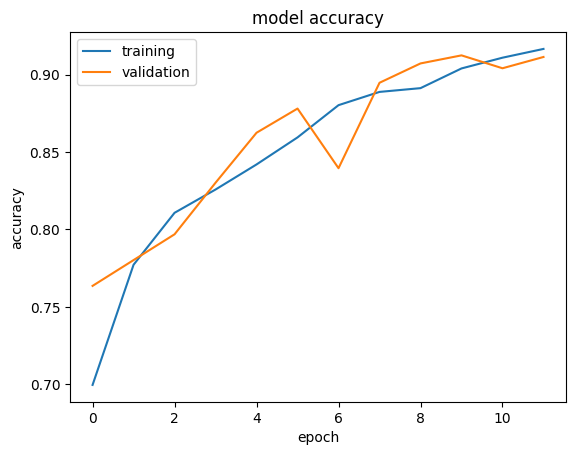

Test loss: 0.25
Test accuracy: 0.902


In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()

print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')

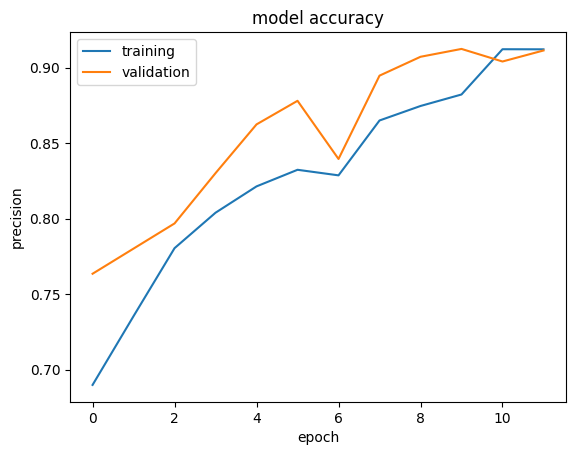

Test loss: 0.25
Test precision: 0.887


In [ ]:
plt.plot(history.history['precision'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()

print(f'Test loss: {loss:.3}')
print(f'Test precision: {precision:.3}')

# Pruebas y predicciones del modelo

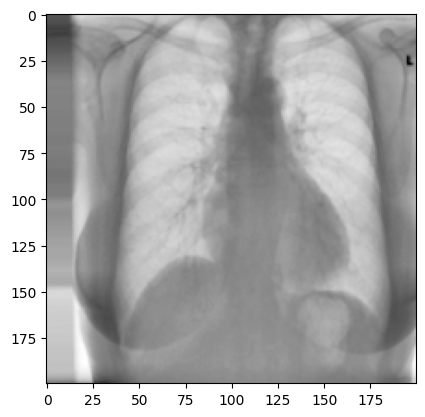

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Condicion predicha del paciente:  0
Condicion real del paciente: 1


In [ ]:
test_img = randint(0,x_test_copia.shape[0])
X_test_img = x_test_copia[test_img]
plt.imshow(X_test_img, cmap='Greys')
plt.show()
X_test_img = X_test_img.reshape(1, 200, 200, 1)
prediction = model.predict(X_test_img)
print('Condicion predicha del paciente: ', prediction.argmax())
print("Condicion real del paciente: 0") if y_test[test_img][0] == 1.0 else print("Condicion real del paciente: 1")